# Factorial Repeated Measures ANOVA with Significant Interaction

In this notebook I will demonstrate how to run a 2x3 repeated measures factorial ANOVA with a dataset that produces a significant interaction between the two independent variables (IVs). As a review, repeated measures designs use the same participants in all levels/ conditions of the IV. This means that each participant contributes multiple data points, one in for each level of all IVs, and these are recorded at different time points. 

The dataset that I will use here comes from the Andy Field textbook series 'Discovering Statistics Using...'. The data relates to a made up and humourous example supposedly investing the effects of alcohol and lighting on people's perceptions of attractiveness. This is referred to as the 'Beer Goggles' effect, the idea being that the more a person drinks, the lower their standards of perception and the more likely they are to rate unattractive people as attractive. The IVs for this study are 'Lighting', which has two levels (Dim/ Bright) and 'Alcohol consumption', which has three levels (0 pints/ 3 pints/ 6 pints). The dependent variable (DV) for this study is 'Attractiveness Rating'. This is an aggregate score of a participants rating of the attractiveness of pictures of faces. Theoretically these face pictures have been validated on a scale measuring how attractive they are in some way. 

In the following sections I will tidy the data so that it is in an appropriate format for analysis, conduct tests of assumptions (specifically Mauchly's test of sphericity), run a two-way repeated measures ANOVA, and then conduct post-hoc tests and tests of simple effects as appropriate depending on which of the results are significant.  

### Cleaning and tidying the data for analysis

The data that I will use for this analysis in currently in a short and wide format. I want to conver this to a long and thin format as this will make it easier to run certain analyses. 

In [1]:
# Importing key software libraries

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pingouin as pg
from statsmodels.stats.anova import AnovaRM

In [2]:
# Importing the dataset.

beer_df = pd.read_csv('BeerGogglesLighting RM 2x3.csv')

beer_df.head()

,dim0,bright0,dim3,bright3,dim6,bright6
0,42.0,35.0,56.0,50.0,95.0,67.0
1,33.0,47.0,54.0,66.0,67.0,67.0
2,36.0,26.0,60.0,65.0,79.0,37.0
3,37.0,39.0,74.0,44.0,83.0,69.0
4,52.0,43.0,69.0,48.0,83.0,70.0


As can be seen above, the dataframe has no participant index column and each column contains on lighting and number of pints (e.g dim0 = dim lighting/ 0 pints). It will take some wrangling to get this data into shape. One approach that may work is to create a participant ID column, then convert the data to long based on lighting, by creating a lighting categorical variable and a rating categorical variable. After this a pints categorical variable could be appended to the dataframe to align with the correct index and lighting categories. 

In [3]:
# Currently the data is short and wide with combinations of the categories saved as six separate variables. 
# I need to convert this to a long and thin dataframe. 
# This can be done using the pandas melt() method
cat_cond = list(beer_df.columns)
groups_long = pd.melt(beer_df, value_vars = cat_cond, value_name = 'rating', ignore_index = False)

In [4]:
groups_long

,variable,rating
0,dim0,42.0
1,dim0,33.0
2,dim0,36.0
3,dim0,37.0
4,dim0,52.0
...,...,...
21,bright6,50.0
22,bright6,56.0
23,bright6,67.0
24,bright6,78.0


Adding a variable for pints. This requires filtering and combining multiple categories (e.g. dim0 and bright0 both mean 0 pints consumed). 

In [5]:
groups_long.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156 entries, 0 to 25
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variable  156 non-null    object 
 1   rating    156 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.7+ KB


In [6]:
# Creating a participant ID column on the original dataframe. 

beer_df['participant_id'] = beer_df.index

In [7]:
beer_df.head()

,dim0,bright0,dim3,bright3,dim6,bright6,participant_id
0,42.0,35.0,56.0,50.0,95.0,67.0,0
1,33.0,47.0,54.0,66.0,67.0,67.0,1
2,36.0,26.0,60.0,65.0,79.0,37.0,2
3,37.0,39.0,74.0,44.0,83.0,69.0,3
4,52.0,43.0,69.0,48.0,83.0,70.0,4


In [8]:
# Mapping this participant_id variable onto the groups_long object.
# Adding a identity variable for each participant to account for the structure in the data due to the participants contributing
# multiple data points. 

groups_long['participant'] = beer_df['participant_id']

groups_long

,variable,rating,participant
0,dim0,42.0,0
1,dim0,33.0,1
2,dim0,36.0,2
3,dim0,37.0,3
4,dim0,52.0,4
...,...,...,...
21,bright6,50.0,21
22,bright6,56.0,22
23,bright6,67.0,23
24,bright6,78.0,24


In [9]:
# Here I have created a new dataframe object containing only the data points when 0 pints of beer were consumed.
pints_0 = groups_long.loc[(groups_long.variable == 'dim0') | (groups_long['variable'] == 'bright0')]

pints_0

,variable,rating,participant
0,dim0,42.0,0
1,dim0,33.0,1
2,dim0,36.0,2
3,dim0,37.0,3
4,dim0,52.0,4
5,dim0,51.0,5
6,dim0,36.0,6
7,dim0,17.0,7
8,dim0,35.0,8
9,dim0,36.0,9


In [10]:
# Here I have created a new dataframe object containing only the data points when 3 pints of beer were consumed.
pints_3 = groups_long.loc[(groups_long.variable == 'dim3') | (groups_long['variable'] == 'bright3')]

pints_3

,variable,rating,participant
0,dim3,56.0,0
1,dim3,54.0,1
2,dim3,60.0,2
3,dim3,74.0,3
4,dim3,69.0,4
5,dim3,41.0,5
6,dim3,71.0,6
7,dim3,69.0,7
8,dim3,54.0,8
9,dim3,55.0,9


In [11]:
# Here I have created a new dataframe object containing only the data points when 6 pints of beer were consumed.
pints_6 = groups_long.loc[(groups_long.variable == 'dim6') | (groups_long['variable'] == 'bright6')]

pints_6

,variable,rating,participant
0,dim6,95.0,0
1,dim6,67.0,1
2,dim6,79.0,2
3,dim6,83.0,3
4,dim6,83.0,4
5,dim6,95.0,5
6,dim6,79.0,6
7,dim6,94.0,7
8,dim6,92.0,8
9,dim6,71.0,9


In [12]:
# Now I am creating a new object that is a list that contains the label 'pints_0' repeated 52 times.
# This is the length of each of the pints_0 data frame object. 
beers_0 = ['pints_0'] * 52

In [13]:
# Now appending this as a variable to the pints_0 dataframe object
pints_0['pints'] = beers_0

C:\Users\robert65\AppData\Local\Temp\ipykernel_3908\4078526642.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pints_0['pints'] = beers_0


In [14]:
# Now I am creating a new object that is a list that contains the label 'pints_3' repeated 52 times.
# This is the length of each of the pints_0 data frame object. 
beers_3 = ['pints_3'] * 52

In [15]:
# Now appending this as a variable to the pints_3 dataframe object
pints_3['pints'] = beers_3

C:\Users\robert65\AppData\Local\Temp\ipykernel_3908\411631095.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pints_3['pints'] = beers_3


In [16]:
# Now I am creating a new object that is a list that contains the label 'pints_6' repeated 52 times.
# This is the length of each of the pints_0 data frame object. 
beers_6 = ['pints_6'] * 52

In [17]:
# Now appending this as a variable to the pints_6 dataframe object
pints_6['pints'] = beers_6

C:\Users\robert65\AppData\Local\Temp\ipykernel_3908\2644492575.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pints_6['pints'] = beers_6


In [18]:
# Checking that the pints variable has been appended to the dataframe. 
pints_0

,variable,rating,participant,pints
0,dim0,42.0,0,pints_0
1,dim0,33.0,1,pints_0
2,dim0,36.0,2,pints_0
3,dim0,37.0,3,pints_0
4,dim0,52.0,4,pints_0
5,dim0,51.0,5,pints_0
6,dim0,36.0,6,pints_0
7,dim0,17.0,7,pints_0
8,dim0,35.0,8,pints_0
9,dim0,36.0,9,pints_0


In [19]:
# Checking that the pints variable has been appended to the dataframe. 
pints_3

,variable,rating,participant,pints
0,dim3,56.0,0,pints_3
1,dim3,54.0,1,pints_3
2,dim3,60.0,2,pints_3
3,dim3,74.0,3,pints_3
4,dim3,69.0,4,pints_3
5,dim3,41.0,5,pints_3
6,dim3,71.0,6,pints_3
7,dim3,69.0,7,pints_3
8,dim3,54.0,8,pints_3
9,dim3,55.0,9,pints_3


In [20]:
# Checking that the pints variable has been appended to the dataframe. 
pints_6

,variable,rating,participant,pints
0,dim6,95.0,0,pints_6
1,dim6,67.0,1,pints_6
2,dim6,79.0,2,pints_6
3,dim6,83.0,3,pints_6
4,dim6,83.0,4,pints_6
5,dim6,95.0,5,pints_6
6,dim6,79.0,6,pints_6
7,dim6,94.0,7,pints_6
8,dim6,92.0,8,pints_6
9,dim6,71.0,9,pints_6


In [21]:
# Now concatenating the three pints dataframe objects (pints_0, pints_3, pints_6) row-wise back into one data frame with 
# all the columns that will be needed for analysis. 

beer_long = pd.concat([pints_0, pints_3, pints_6], axis = 0)

In [22]:
# They have been successfully combined into a new dataframe object ready for analysis. 
beer_long

,variable,rating,participant,pints
0,dim0,42.0,0,pints_0
1,dim0,33.0,1,pints_0
2,dim0,36.0,2,pints_0
3,dim0,37.0,3,pints_0
4,dim0,52.0,4,pints_0
...,...,...,...,...
21,bright6,50.0,21,pints_6
22,bright6,56.0,22,pints_6
23,bright6,67.0,23,pints_6
24,bright6,78.0,24,pints_6


In [23]:
# The lighting variable, just called variable should have only two groups (dim and bright). It currently has 6 because
# dim0, dim3, dim6, bright0, bright3, bright6 are different strings so are treated as different categories. I want
# to replace the three dim strings with just one group 'dim', and the three bright strings with just 'bright'. 
# I will use the replace method and pass it a dictionary to do this. 

beer_long['variable'] = beer_long['variable'].replace({'dim0': 'dim', 'dim3': 'dim', 'dim6': 'dim', 
                                                      'bright0': 'bright', 'bright3': 'bright', 'bright6': 'bright'})

In [24]:
beer_long

,variable,rating,participant,pints
0,dim,42.0,0,pints_0
1,dim,33.0,1,pints_0
2,dim,36.0,2,pints_0
3,dim,37.0,3,pints_0
4,dim,52.0,4,pints_0
...,...,...,...,...
21,bright,50.0,21,pints_6
22,bright,56.0,22,pints_6
23,bright,67.0,23,pints_6
24,bright,78.0,24,pints_6


The above steps for cleaning and tidying the data were complex and it took some manipulation to get the data frame into the sort of condition that is best to run the two-way ANOVA. It is worth keeping in mind that much of the work in data science when dealing with datasets from various sources, certainly in relation to data you have not collected yourself, involves time spent cleaning up and organising the data. 

### Mauchly's test of sphericity

With the data in an appropriate format, I will now use Mauchly's test of sphericity. This tests the assumption that variances of the differences of all possible pairs of within-subjects conditions are equal. If sphericity is violated, then variance calculations may be distorted resulting in an inflated F ratio. If the assumption of sphericity is not violated then we can assume that the data is appropriate for use with a parametric statistical test like ANOVA.

In [25]:
# Running Mauchly's test using the pg.sphericity method.  

pg.sphericity(data = beer_long, dv = 'rating', subject = 'participant', within = ['variable', 'pints'])

SpherResults(spher=True, W=0.9487404851245405, chi2=1.2628795002438233, dof=2, pval=0.5318255536312061)

The result of Mauchly's test indicates we are probably safe to assume sphericity in the dataset as we have a non-significant result so we do not reject the null hypotheses of sphericity and the variances of all possible pairs of within-subjects difference scores are likely to be equal. We can proceed with the standard repeated measures ANOVA for our analysis. 

Mauchly's: W = 0.95, X2(2) = 1.26, p = 0.53

### 2x3 Repeated Measures ANOVA

There are a number of ways in which the ANOVA analysis can be run. Here I am going to use the pingouin rm_anova method rather than fitting the formula using statsmodels. 

In [26]:
# Conducting the 2x3 repeated measures ANOVA using the pingouin rm_anova method. 
# The parameters for this method are the data, the DV, the within subjects factors, the subject/ participant ID 
# (to account for multiple datapoints from the same participants), detailed = True returns the result as a pandas dataframe.
# Note the difference to one-way RM ANOVA, we pass a list of both within-subjects IVs to the within paramter.

res = pg.rm_anova(data = beer_long, dv = 'rating', within = ['variable', 'pints'], subject = 'participant', detailed = True)

res

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,variable,3790.775641,1,25,3790.775641,40.695839,1.117479e-06,1.117479e-06,0.187881,1.000000
1,pints,27388.551282,2,50,13694.275641,97.222060,5.885186e-18,2.459816e-16,0.625677,0.896585
2,variable * pints,3668.089744,2,50,1834.044872,19.763797,4.735080e-07,8.305790e-07,0.182912,0.951240


The above ANOVA table output shows we have a significant model. We can see that there is a significant main effect of lighting (here labelled variable) (F(1, 25) = 40.70, p < 0.001); a significant main effect of pints (F(2, 50) = 97.22, p < 0.001; and a significant interaction between lighting and beer (F(2, 50) = 19.76, P < 0.001). 

Although, we have significant main effects, the fact that we have a significant interation tells us that those main effects are not likely to be consistent across all levels of the one IV in interaction with the other IV. A sensible way to proceed is to obtain an interaction plot for the means across all interaction groups and some means for each group, before conducting some simple effects comparisons.   

<AxesSubplot:xlabel='pints', ylabel='rating'>

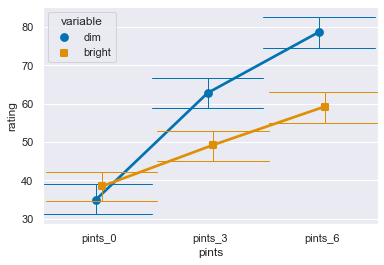

In [27]:
# Creating an interaction plot to visualise the differences between the group means using seaborn pointplot.

sns.set()
sns.pointplot(data = beer_long, x = 'pints', y = 'rating', hue = 'variable', dodge = True, 
              markers = ['o', 's'], capsize = 1, errwidth = 1, palette = 'colorblind')

The above interaction plot show the pattern of differences between the interaction group means. We can see that attractiveness ratings were higher in the dim lighting condition (compared to the bright lighting condition) when people had drunk 3 or 6 pints but not when they had drunk 0 pints, where the group means were very similar. Considering the dim lighting condition in isolation (blue line) we can see that attractiveness ratings were higher in the 3 pints condition compared to the 0 pints condition, and higher in the 6 pints condition than both the three pints and 6 pints condition. Similarly, when just looking at the bright condition (orange line), we can see that attractiveness ratings were higher whe  three pints were drunk compared to 0 pints, and for the 6 pints condition attractiveness ratings were higher than both the 0 pints and 3 pints condition. The differences between group means where the error bars (95% Confidence Intervals) don't overlap provide a strong indication that those means will be statistically significantly different. However, to confirm these we would want to do simple effects tests to compare the different groups using some type of p-value adjustment to control for type 1 errors. Below I obtain a table of descriptive statistics and then conduct simple effects tests. 

In [28]:
# Creating an object that represents all combinations of groups in the interaction. 
interaction_groups = "variable_" + beer_long.variable.astype(str) + "&" + "pint_" + beer_long.pints.astype(str)

interaction_groups

0        variable_dim&pint_pints_0
1        variable_dim&pint_pints_0
2        variable_dim&pint_pints_0
3        variable_dim&pint_pints_0
4        variable_dim&pint_pints_0
                  ...             
21    variable_bright&pint_pints_6
22    variable_bright&pint_pints_6
23    variable_bright&pint_pints_6
24    variable_bright&pint_pints_6
25    variable_bright&pint_pints_6
Length: 156, dtype: object

In [29]:
# Appending the interaction_groups column to the consumption data frame. 

beer_long["inter_grp"] = interaction_groups

beer_long.head()

,variable,rating,participant,pints,inter_grp
0,dim,42.0,0,pints_0,variable_dim&pint_pints_0
1,dim,33.0,1,pints_0,variable_dim&pint_pints_0
2,dim,36.0,2,pints_0,variable_dim&pint_pints_0
3,dim,37.0,3,pints_0,variable_dim&pint_pints_0
4,dim,52.0,4,pints_0,variable_dim&pint_pints_0


### Descriptive statistics (means) for the interaction groups 

In [30]:
# Next obtaining descriptive statistics by interaction group for comparison. 

# Creating a new object for each of the interaction groups:

dim_pints0 = beer_long.loc[beer_long.inter_grp == 'variable_dim&pint_pints_0']['rating']
dim_pints3 = beer_long.loc[beer_long.inter_grp == 'variable_dim&pint_pints_3']['rating']
dim_pints6 = beer_long.loc[beer_long.inter_grp == 'variable_dim&pint_pints_6']['rating']
bright_pints0 = beer_long.loc[beer_long.inter_grp == 'variable_bright&pint_pints_0']['rating']
bright_pints3 = beer_long.loc[beer_long.inter_grp == 'variable_bright&pint_pints_3']['rating']
bright_pints6 = beer_long.loc[beer_long.inter_grp == 'variable_bright&pint_pints_6']['rating']


In [31]:
# Printing the mean for each of the above interaction group objects. 

print(f"Dim & 0 Pints: {dim_pints0.mean():.2f}")
print(f"Dim & 3 Pints: {dim_pints3.mean():.2f}")
print(f"Dim & 6 Pints: {dim_pints6.mean():.2f}")

print(f"Bright & 0 Pints: {bright_pints0.mean():.2f}")
print(f"Bright & 3 Pints: {bright_pints3.mean():.2f}")
print(f"Bright & 6 Pints: {bright_pints6.mean():.2f}")


Dim & 0 Pints: 35.00
Dim & 3 Pints: 62.77
Dim & 6 Pints: 78.69
Bright & 0 Pints: 38.42
Bright & 3 Pints: 49.23
Bright & 6 Pints: 59.23


### Simple Effects Tests

To conduct follow up tests of simple effects I am going to try using the pairwise_tests method from the pingouin software library. I am going to use a Bonferroni correction to adjust the p-value and have to specify this using the padjust argument. 

In [32]:
simple_eff = pg.pairwise_tests(data = beer_long, dv = 'rating', within = 'inter_grp', subject = 'participant', padjust = 'bonf')

simple_eff.round(3)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,inter_grp,variable_bright&pint_pints_0,variable_bright&pint_pints_3,True,True,-3.717,25.0,two-sided,0.001,0.015,bonf,33.8,-1.061
1,inter_grp,variable_bright&pint_pints_0,variable_bright&pint_pints_6,True,True,-8.501,25.0,two-sided,0.000,0.000,bonf,1.665e+06,-1.999
2,inter_grp,variable_bright&pint_pints_0,variable_dim&pint_pints_0,True,True,1.219,25.0,two-sided,0.234,1.000,bonf,0.403,0.337
3,inter_grp,variable_bright&pint_pints_0,variable_dim&pint_pints_3,True,True,-8.475,25.0,two-sided,0.000,0.000,bonf,1.578e+06,-2.328
4,inter_grp,variable_bright&pint_pints_0,variable_dim&pint_pints_6,True,True,-14.085,25.0,two-sided,0.000,0.000,bonf,3.303e+10,-3.888
5,inter_grp,variable_bright&pint_pints_3,variable_bright&pint_pints_6,True,True,-3.411,25.0,two-sided,0.002,0.033,bonf,17.233,-0.933
6,inter_grp,variable_bright&pint_pints_3,variable_dim&pint_pints_0,True,True,4.125,25.0,two-sided,0.000,0.005,bonf,85.099,1.357
7,inter_grp,variable_bright&pint_pints_3,variable_dim&pint_pints_3,True,True,-5.213,25.0,two-sided,0.000,0.000,bonf,1071.014,-1.257
8,inter_grp,variable_bright&pint_pints_3,variable_dim&pint_pints_6,True,True,-9.373,25.0,two-sided,0.000,0.000,bonf,9.701e+06,-2.761
9,inter_grp,variable_bright&pint_pints_6,variable_dim&pint_pints_0,True,True,8.455,25.0,two-sided,0.000,0.000,bonf,1.513e+06,2.263


This is a very thorough set of pairwise comparisons using a Bonferroni correction. We can see that there are a number of statistically significant differences. The only groups that were not statistically significant are the: 'Bright & 0 Pints' and the 'Dim & 0 Pints' groups. This makes sense as these groups are very similar if you check the interaction plot; and the 'Bright & 6 Pints' compared to the 'Dim & 3 Pints' group, again, check the interaction plot and it can be see that there is some overlap in the error bars for these two groups. 

A full list of the results:

- Bright_0_Pints (Mean = 38.42) V Bright_3_pints (Mean = 49.23). Significantly different (t(25) = 3.72, p = 0.015).
- Bright_0_Pints (Mean = 38.42) V Bright_6_pints (Mean = 59.23). Significantly different (t(25) = 8.50, p < 0.001).
- Bright_0_Pints (Mean = 38.42) V Dim_0_pints (Mean = 35.00). Not significantly different (t(25) = 1.22, p = 1.000).
- Bright_0_Pints (Mean = 38.42) V Dim_3_pints (Mean = 62.77). Significantly different (t(25) = 8.48, p < 0.001).
- Bright_0_Pints (Mean = 38.42) V Dim_6_pints (Mean = 78.69). Significantly different (t(25) = 14.09, p < 0.001).
- Bright_3_Pints (Mean = 49.23) V Bright_6_pints (Mean = 59.23). Significantly different (t(25) = 3.41, p = 0.03).
- Bright_3_Pints (Mean = 49.23) V Dim_0_pints (Mean = 35.00). Significantly different (t(25) = 4.13, p = 0.005).
- Bright_3_Pints (Mean = 49.23) V Dim_3_pints (Mean = 62.77). Significantly different (t(25) = 5.21, p < 0.001).
- Bright_3_Pints (Mean = 49.23) V Dim_6_pints (Mean = 78.69). Significantly different (t(25) = 9.37, p < 0.001).
- Bright_6_Pints (Mean = 59.23) V Dim_0_pints (Mean = 35.00). Significantly different (t(25) = 8.46, p < 0.001).
- Bright_6_Pints (Mean = 59.23) V Dim_3_pints (Mean = 62.77). Not significantly different (t(25) = 1.29, p = 1.000).
- Bright_6_Pints (Mean = 59.23) V Dim_6_pints (Mean = 78.69). Significantly different (t(25) = 7.46, p < 0.001).
- Dim_0_Pints (Mean = 35.00) V Dim_3_pints (Mean = 62.77). Significantly different (t(25) = 7.83, p < 0.001).
- Dim_0_Pints (Mean = 35.00) V Dim_6_pints (Mean = 78.69). Significantly different (t(25) = 16.79, p < 0.001).
- Dim_3_Pints (Mean = 62.77) V Dim_6_pints (Mean = 78.69). Significantly different (t(25) = 4.69, p = 0.001).

These results as a whole seem to indicate that the amount of alcohol that was consumed influenced participants ratings of attractiveness with higher ratings being associated with higher levels of alcohol consumed. Lighting seemed to influence rating in interaction with alcohol with those rating faces in dim lighting giving higher attractiveness ratings than those racing faces in bright lighting conditions. This difference between lighting conditions on attractiveness ratings was not consistent and did not occur when participants had not consumed any alcohol. 